In [32]:
#--------------------------------------------------------------------------------------
#
#     $Source: TestFlakiness/FindTestAddedBetweenIteration.py $
#
#  $Copyright: (c) 2018 Bentley Systems, Incorporated. All rights reserved. $
#
#--------------------------------------------------------------------------------------
import os
import csv
import sys
import sqlite3
import argparse
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


#Common Scripts to be used by any task
# srcpath = os.getenv('SrcRoot')
# commonScriptsDir = os.path.join(srcpath, 'DgnDbTestingScripts', 'CommonTasks')
# sys.path.append(commonScriptsDir)
# dppath=os.path.join(*[srcpath,"DgnDbTestingScripts","TestFlakiness","TestsCatalog.db"])

import FindStream
from SqliteDatabase import Database


#-------------------------------------------------------------------------------------------
# bsimethod                                     Ridha.Malik                    07/2018
#-------------------------------------------------------------------------------------------
def StreamId(c,Stream):
    '''
        Retruns the stream Id from database
    '''
    c.execute("SELECT  StreamId FROM Stream WHERE name = ?",(Stream ,))
    result = c.fetchall()
    if len(result) != 0:
        id=result[0][0]
        return id
    else:
        print "Stream doesnot exists in testcatalog"
        exit (0)
#-------------------------------------------------------------------------------------------
# bsimethod                                     Ridha.Malik                    07/2018
#-------------------------------------------------------------------------------------------
def valid_date(s):
    try:
        return datetime.datetime.strptime(s, "%Y-%m-%d")
    except ValueError:
        msg = "Not a valid date its format YYYY-MM-DD should be: '{0}'.".format(s)
        raise argparse.ArgumentTypeError(msg)

# Temporarily assign variables that are to be taken from Command line

In [33]:
Stream = "bim0200"
StartDate="2017-09-01"
# StartDate=datetime.date.strftime(StartDate, "%Y-%m-%d")
EndDate="2018-07-01"
# EndDate=datetime.date.strftime(EndDate, "%Y-%m-%d") 

In [34]:
db=Database("TestsCatalog.db")
db.connectDatabase()
c=db.cursor

streamid=StreamId(c,Stream)

# Divide the time frame into months

In [46]:
months = pd.date_range(start = StartDate, end = EndDate, freq='M', normalize=False).date

# Get the number of tests added before start date

In [47]:
streamid=StreamId(c,Stream)
sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + ' AND Date <' + '\'' + StartDate + '\'' + 'GROUP BY component;'
c.execute(sql)
data=c.fetchall()
if len(data) == 0:
    print "No Test added prior to "+StartDate
df = pd.DataFrame.from_records(data, columns=['Component', 'Prior Count'])

In [48]:
df

,Component,Prior Count
0,BeHttp,165
1,BeSQLite,91
2,BeSecurity,25
3,Bentley,543
4,ConstructionSchema,29
5,DgnClientFx,372
6,DgnDisplay,25
7,DgnPlatform,538
8,DgnV8,166
9,Dwg,5


# Get the number of counts for each month untill EndDate and add that to the dataframe

In [49]:
for m in months:
    sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + " AND Date < '" + str(m) + "' GROUP BY component;"
    c.execute(sql)
    data=c.fetchall()
    df0 = pd.DataFrame.from_records(data, columns=['Component', 'Count'+str(m.month)+"-"+str(m.year)])
    
    df = pd.merge(df, df0, on='Component', how='outer')
    df.fillna(0, inplace=True)

In [50]:
df

,Component,Prior Count,Count9-2017,Count10-2017,Count11-2017,Count12-2017,Count1-2018,Count2-2018,Count3-2018,Count4-2018,Count5-2018,Count6-2018
0,BeHttp,165.0,165.0,165.0,205.0,216.0,247.0,258.0,261.0,270.0,272.0,272
1,BeSQLite,91.0,92.0,92.0,92.0,92.0,97.0,97.0,98.0,102.0,102.0,102
2,BeSecurity,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25
3,Bentley,543.0,543.0,544.0,545.0,545.0,548.0,555.0,555.0,568.0,568.0,568
4,ConstructionSchema,29.0,29.0,29.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30
5,DgnClientFx,372.0,374.0,376.0,379.0,379.0,384.0,389.0,389.0,389.0,389.0,389
6,DgnDisplay,25.0,25.0,25.0,33.0,33.0,37.0,37.0,37.0,37.0,37.0,37
7,DgnPlatform,538.0,539.0,555.0,566.0,566.0,569.0,576.0,583.0,586.0,601.0,615
8,DgnV8,166.0,173.0,173.0,183.0,183.0,188.0,191.0,196.0,196.0,203.0,205
9,Dwg,5.0,5.0,5.0,5.0,5.0,7.0,11.0,11.0,12.0,13.0,13


# Plot a line graph from start date till the end date

In [51]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(df))]

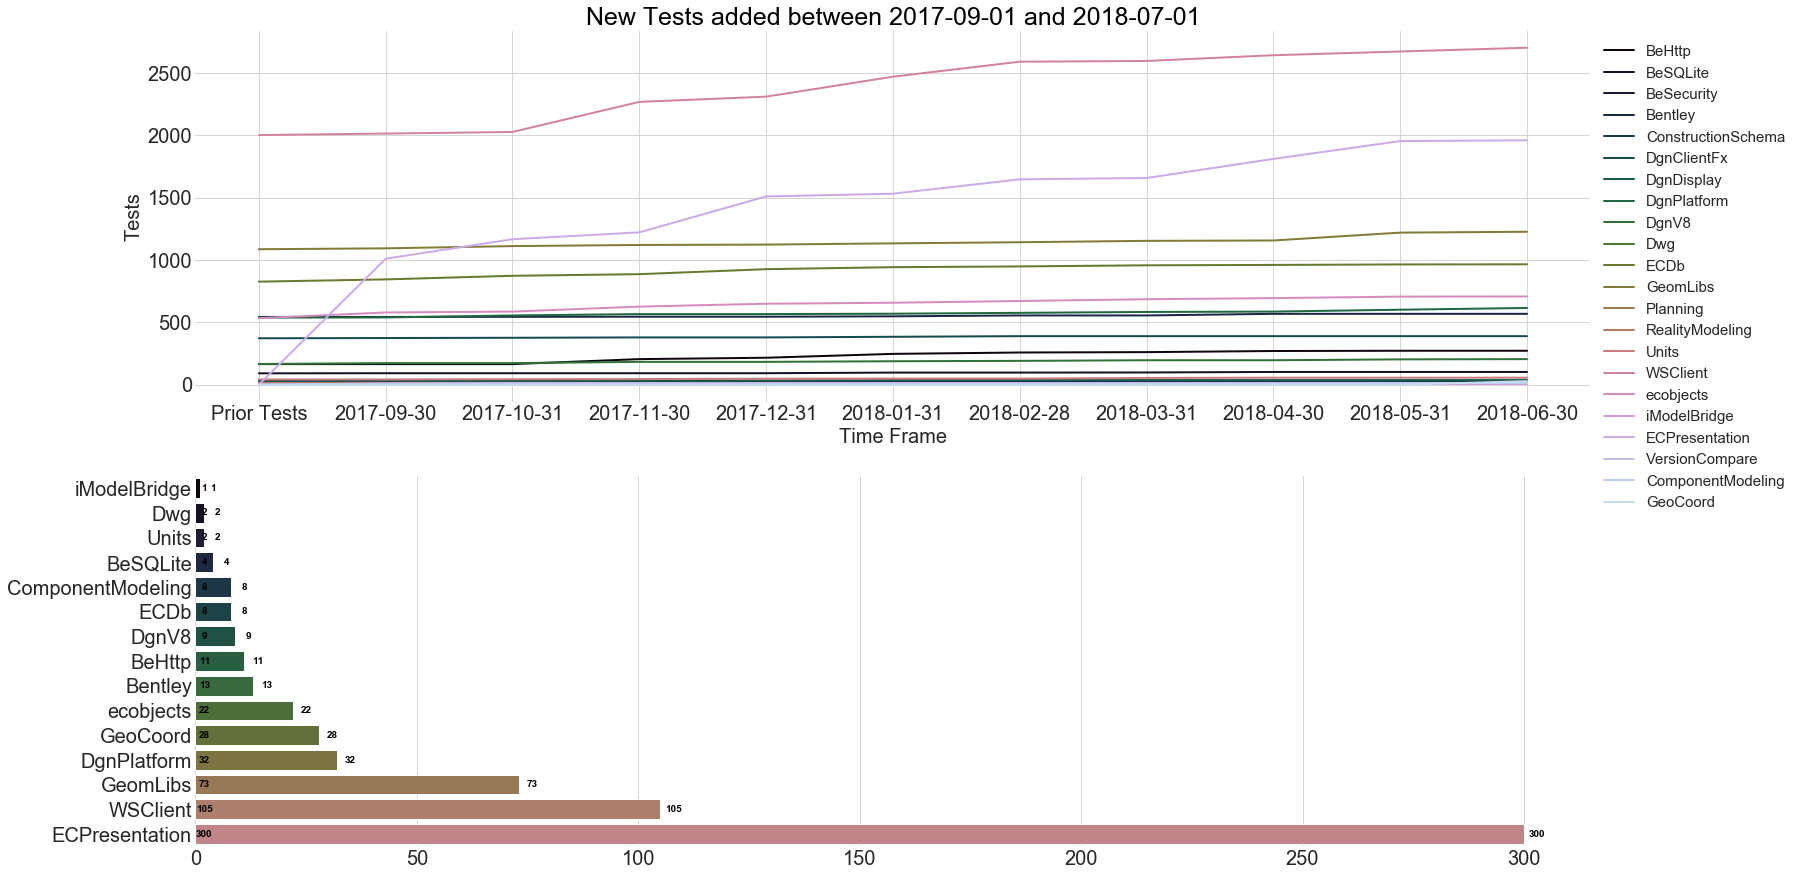

In [61]:
plt.figure(figsize=(25,15))
plt.subplot(2, 1, 1)

# multiple line plot
for i, row in df.iterrows():
#     print row
    plt.plot(row[1:], label = row[0], color = colors[i], linewidth = 2.0)
#     p.set_urls(['http://www.bbc.co.uk/news', 'http://www.google.com', None])

    # Add legend    
plt.legend(loc='upper left', ncol=1, fontsize=15, bbox_to_anchor=(1, 1))



# # Add titles
plt.title("New Tests added between "+StartDate+" and "+EndDate, fontsize=25, fontweight=0.5, color='Black')
plt.xlabel("Time Frame", fontsize=20)
plt.ylabel("Tests", fontsize=20)

x=['Prior Tests'] 
x.extend(months)

plt.xticks(np.arange(len(x)), x, fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(2, 1, 2)



df1=pd.read_csv("NewlyAddedTestsReport.csv")
data = np.unique(df1.Component, return_counts=True)

sData = zip(*sorted(zip(data[1], data[0])))
Y, X = sData
X = np.array(X)
Y = np.array(Y)

size = np.shape(X)[0]

# fig = plt.figure(figsize=(size+5,size))
sns.set_style("whitegrid")

colors = sns.color_palette("cubehelix", len(df1.Component.unique()) + 10)

for i in range(size):
    g = sns.barplot(y=X[i:i+1], x=Y[i:i+1], color=colors[i], order = X, url = X[i]+'.svg', orient='h')
    g.text(Y[i] + 3, i + 0.1, Y[i], color='black', ha="center", weight="bold")
    g.text(2, i + 0.1, Y[i], color='black', ha="center", weight="bold")


sns.despine(left=True)
g.tick_params(labelsize=20)
plt.savefig('Main2.svg', dpi=300, orientation='landscape', )
plt.show()

In [ ]:

# sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + ' AND Date <' + '\'' + StartDate + '\'' + 'GROUP BY component;'
# c.execute(sql)
# data=c.fetchall()
# dfOld = pd.DataFrame.from_records(data, columns=['Component', 'Count'])

In [ ]:
# sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + " AND Date BETWEEN '" + StartDate + "' AND '" + EndDate + "' GROUP BY component;"
# c.execute(sql)
# data=c.fetchall()
# dfNew = pd.DataFrame.from_records(data, columns=['Component', 'NewCount'])

In [ ]:
# df = pd.merge(dfOld, dfNew, on='Component', how='outer')
# df.fillna(0, inplace=True)


In [ ]:
# df.NewCount = df.Count+df.NewCount


In [ ]:
import seaborn as sns
sns.set(style="ticks")


sns.lineplot(data=dfOld['Count'])

In [ ]:
print times.date

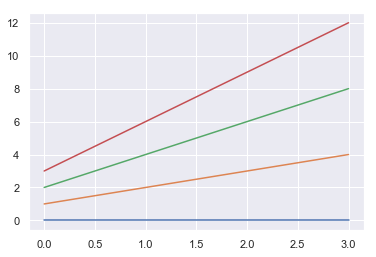

In [140]:
import matplotlib.pyplot as plt

fig = plt.figure()
plot = fig.add_subplot(111)

# create some curves
for i in range(4):
    plot.plot(
        [i*1,i*2,i*3,i*4],
        gid=i)

def on_plot_hover(event):
    for curve in plot.get_lines():
        if curve.contains(event)[0]:
            print "over %s" % curve.get_gid()

fig.canvas.mpl_connect('motion_notify_event', on_plot_hover)           
plt.show()

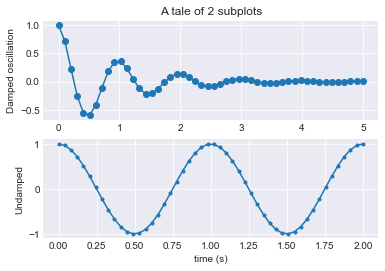

In [26]:
import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.show()